In [1]:
import numpy as np
import ROOT
import pandas as pd
import matplotlib.pyplot as plt
import energyflow as ef
from energyflow.archs.dnn import DNN
import data_handler as dh
import omnifold
from omnifold_bdt import binned_omnifold, unbinned_omnifold
import energyflow as ef
import modplot
from omnifold import DataLoader, MLP, MultiFold
import time

2024-10-15 16:26:13.496257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 16:26:13.518483: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 16:26:13.525138: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 16:26:13.543125: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-15 16:26:15.684171: W tensorflow/compiler/tf2

Horovod not found, will continue with single only GPUs.


In [2]:
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif'

In [3]:
# There are two different smearing functions that we consider when generating data
# These are taken from the RooUnfold tutorials (github.com/vincecr0ft/RooUnfoldTutorials)
# The two datasets use different binning
smearing_function = "smear"
if smearing_function == "calo":
    sim_bins  = 40
    MC_bins   = 40
    sim_low   = 0
    sim_high  = 10
    MC_low    = 0
    MC_high   = 10
else:
    sim_bins  = 40
    MC_bins   = 40
    sim_low   = -10
    sim_high  = 10
    MC_low    = -10
    MC_high   = 10

In [4]:
MC_hist  = ROOT.TH1D("MC_hist", "MC_hist", MC_bins, MC_low, MC_high)
sim_hist = ROOT.TH1D("sim_hist", "sim_hist", sim_bins, sim_low, sim_high)
response = ROOT.RooUnfoldResponse(sim_bins, sim_low, sim_high, MC_bins, MC_low, MC_high)
true_hist     = ROOT.TH1D ("true_hist", "true_hist", MC_bins, MC_low, MC_high)
measured_hist = ROOT.TH1D ("measured_hist", "measured_hist", sim_bins, sim_low, sim_high)

In [5]:
num_MC_data_points  = 100000
num_iterations = 4

In [6]:
# Generating pseudo data
unbinned_MC_data = []
unbinned_sim_data = []
unbinned_true_data = []
unbinned_measured_data = []
sim_pass_reco = []
sim_pass_truth = []
measured_pass_reco = []
measured_pass_truth = []
for i in range(num_MC_data_points):
    # Generating MC data
    if smearing_function == "calo":
      xt = ROOT.gRandom.BreitWigner(5.0, 1.0)
    else:
      xt = ROOT.gRandom.BreitWigner(0.3, 2.5)
    MC_hist.Fill(xt)
    unbinned_MC_data.append(xt)
    x = dh.smearing_wrapper(xt, smearing_function)
    unbinned_sim_data.append(x)
    if xt < MC_low or xt > MC_high:
        sim_pass_truth.append(False)
    else:
        sim_pass_truth.append(True)
    if x != None:
        response.Fill(x, xt)
        sim_hist.Fill(x)
        if x < sim_low or x > sim_high:
            sim_pass_reco.append(False)
        else:
            sim_pass_reco.append(True)
    else:
        response.Miss(xt)
        sim_pass_reco.append(False)

for i in range(int(num_MC_data_points/10)):
    if smearing_function == "calo":
        xt = ROOT.gRandom.Gaus (5.0, 1.0)
    else:
        xt = ROOT.gRandom.Gaus (0.0, 2.0)
    unbinned_true_data.append(xt)
    true_hist.Fill(xt)
    if xt < MC_low or xt > MC_high:
        measured_pass_truth.append(False)
    else:
        measured_pass_truth.append(True)
    x = dh.smearing_wrapper(xt, smearing_function)
    unbinned_measured_data.append(x)
    if x != None:
        measured_hist.Fill(x)
        if x < sim_low or x > sim_high:
            measured_pass_reco.append(False)
        else:
            measured_pass_reco.append(True)
    else:
        measured_pass_reco.append(False)
    
unbinned_MC_data = np.array(unbinned_MC_data, dtype=np.float32)
unbinned_sim_data = np.array(unbinned_sim_data, dtype=np.float32)
unbinned_true_data = np.array(unbinned_true_data, dtype=np.float32)
unbinned_measured_data = np.array(unbinned_measured_data, dtype=np.float32)
sim_pass_reco = np.array(sim_pass_reco, dtype=bool)
sim_pass_truth = np.array(sim_pass_truth, dtype=bool)
measured_pass_reco = np.array(measured_pass_reco, dtype=bool)
measured_pass_truth = np.array(measured_pass_truth, dtype=bool)

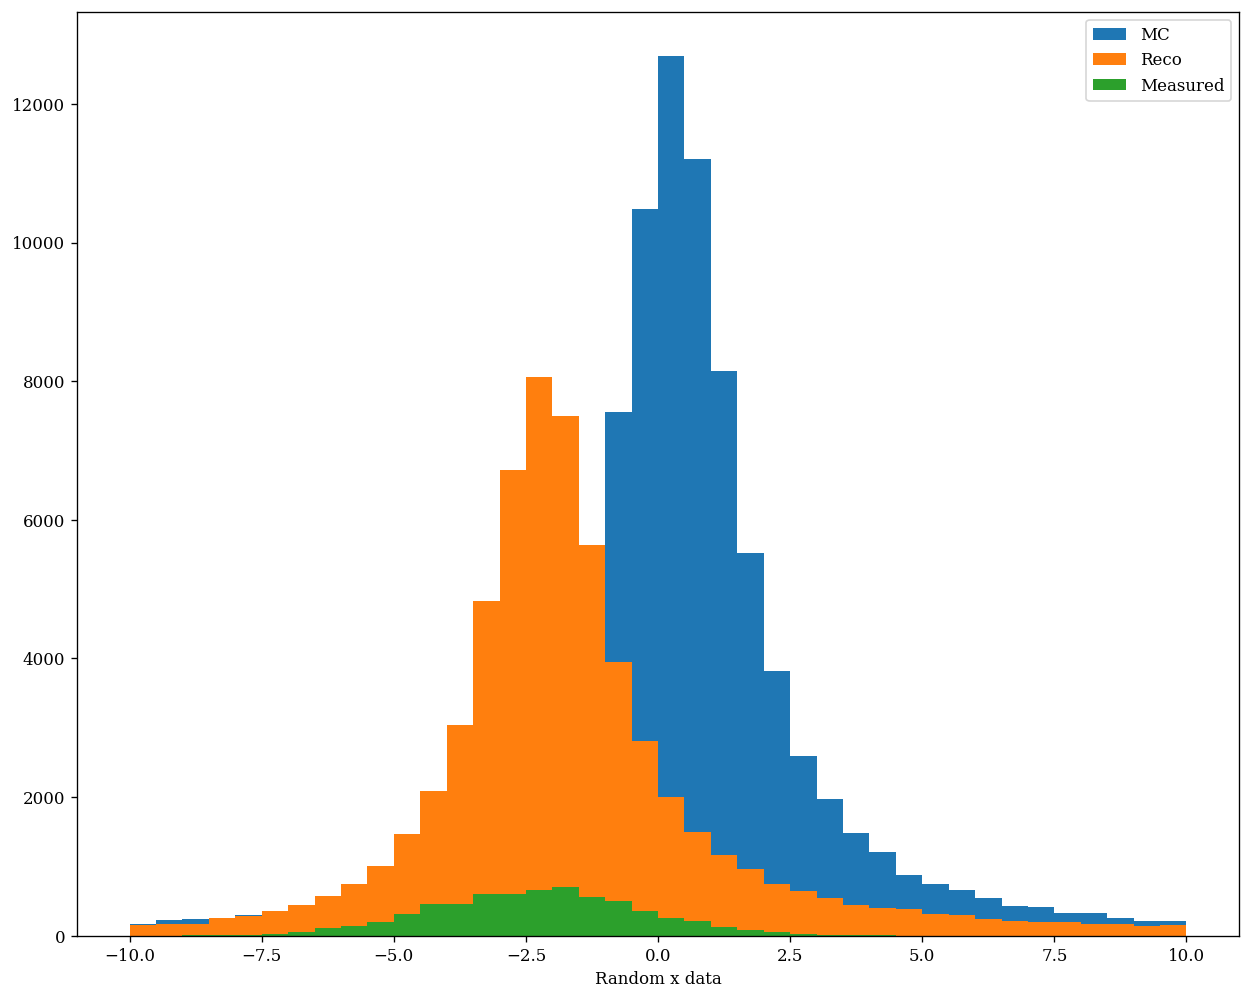

In [7]:
fig = plt.figure(figsize=(12.5,10))
plt.hist(unbinned_MC_data[sim_pass_truth], bins = MC_bins, range=(MC_low, MC_high), label = "MC", histtype='stepfilled')
plt.hist(unbinned_sim_data[sim_pass_reco], bins = sim_bins, range=(sim_low, sim_high), label = "Reco", histtype='stepfilled')
plt.hist(unbinned_measured_data[measured_pass_reco], bins = sim_bins, range=(sim_low, sim_high), label = "Measured", histtype='stepfilled')
plt.legend()
plt.xlabel("Random x data")
fig.savefig('./generated_data.pdf')

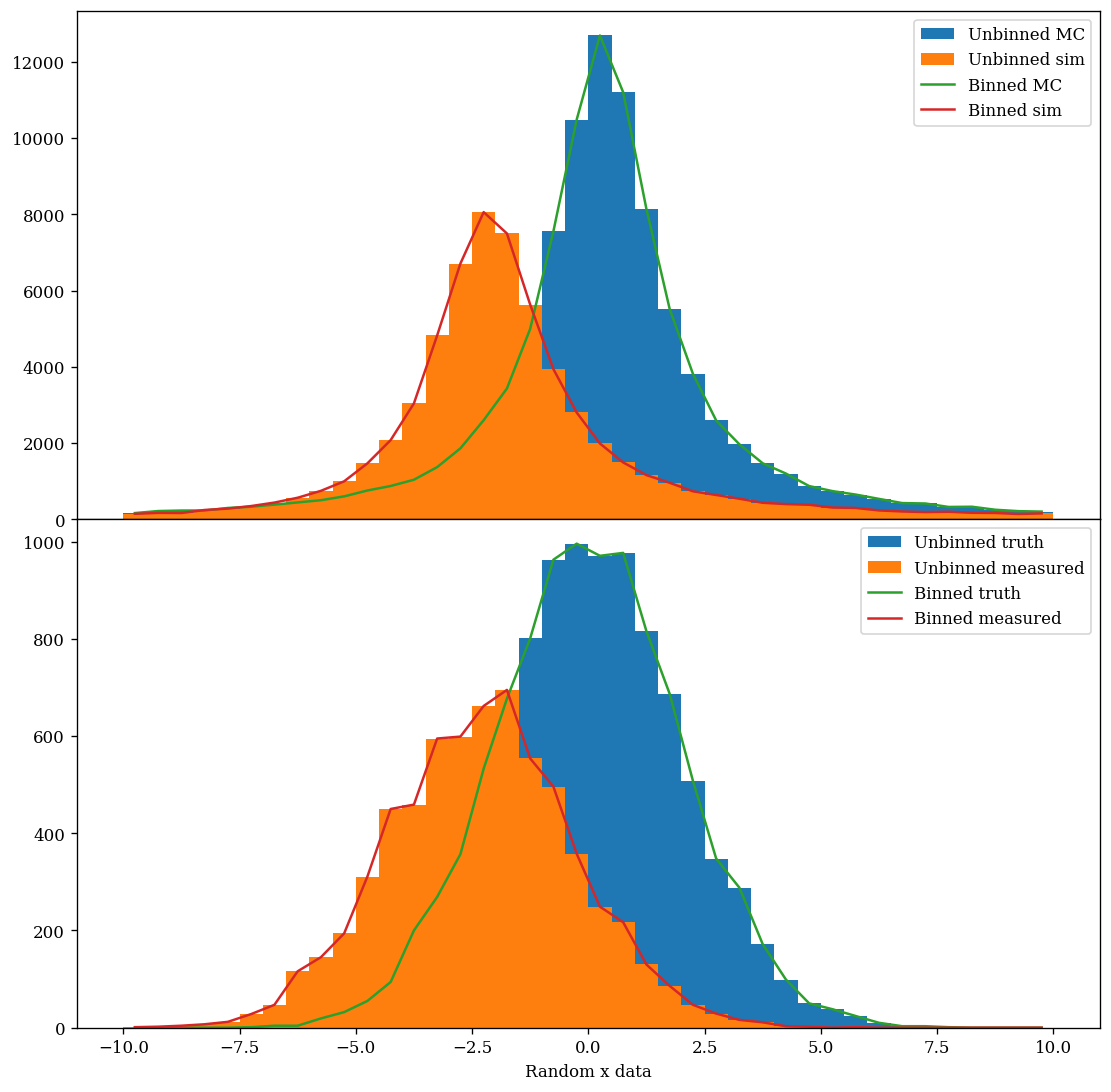

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(11,11), sharex=True)
unbinned_MC, _, _ = axs[0].hist(unbinned_MC_data[sim_pass_truth], bins = MC_bins, range=(MC_low, MC_high), label = "Unbinned MC")
unbinned_sim, _, _ = axs[0].hist(unbinned_sim_data[sim_pass_reco], bins = sim_bins, range=(sim_low, sim_high), label = "Unbinned sim")
MC_counts, MC_bin_centers = dh.TH1_to_numpy(MC_hist)
axs[0].plot(MC_bin_centers, MC_counts, label = "Binned MC")
sim_counts, sim_bin_centers = dh.TH1_to_numpy(sim_hist)
axs[0].plot(sim_bin_centers, sim_counts, label = "Binned sim")
axs[0].legend()

axs[1].hist(unbinned_true_data[measured_pass_truth], bins = MC_bins, range=(MC_low, MC_high), label = "Unbinned truth")
axs[1].hist(unbinned_measured_data[measured_pass_reco], bins = sim_bins, range=(sim_low, sim_high), label = "Unbinned measured")
truth_counts, truth_bin_centers = dh.TH1_to_numpy(true_hist)
axs[1].plot(truth_bin_centers, truth_counts, label = "Binned truth")
measured_counts, measured_bin_centers = dh.TH1_to_numpy(measured_hist)
axs[1].plot(measured_bin_centers, measured_counts, label = "Binned measured")
axs[1].legend()
axs[1].set_xlabel("Random x data")
plt.subplots_adjust(wspace=0, hspace=0)

### DNN Omnifold

In [9]:
# Normalize the data for the DNN
# Normalizing using only the data that passes truth/reco
from sklearn.preprocessing import StandardScaler
unbinned_MC_data = np.expand_dims(unbinned_MC_data, axis=1)
unbinned_sim_data = np.expand_dims(unbinned_sim_data, axis=1)
unbinned_measured_data = np.expand_dims(unbinned_measured_data, axis=1)

standardized_MC_data = np.copy(unbinned_MC_data)
standardized_sim_data = np.copy(unbinned_sim_data)
standardized_measured_data = np.copy(unbinned_measured_data)

MC_scaler = StandardScaler()
standardized_MC_data[sim_pass_truth] = MC_scaler.fit_transform(unbinned_MC_data[sim_pass_truth])
sim_scaler = StandardScaler()
standardized_sim_data[sim_pass_reco] = sim_scaler.fit_transform(unbinned_sim_data[sim_pass_reco])
measured_scaler = StandardScaler()
standardized_measured_data[measured_pass_reco] = measured_scaler.fit_transform(unbinned_measured_data[measured_pass_reco])

In [10]:
MC_dataloader = DataLoader(reco = unbinned_sim_data,
                           gen = unbinned_MC_data,
                           pass_reco = sim_pass_reco,
                           pass_gen = sim_pass_truth)
data_dataloader = DataLoader(reco = unbinned_measured_data,
                             pass_reco = measured_pass_reco)
ndim = 1
reco_model = MLP(ndim)
gen_model = MLP(ndim)
omnifold_dnn = MultiFold(
    name="BDT Omnifold paper, Gaussian",
    model_reco=reco_model,
    model_gen=gen_model,
    data=data_dataloader,
    mc=MC_dataloader,
    niter = num_iterations
)
start_time = time.time()
omnifold_dnn.Unfold()
omnifold_dnn_weights = omnifold_dnn.weights_push
end_time = time.time()
dnn_unbinned_multi_time = end_time-start_time
print(f"Total time {end_time-start_time}")

INFO: Creating weights ...
INFO: Creating weights ...
859 training steps at reco and 1562 steps at gen
ITERATION: 1
RUNNING STEP 1
Last val loss nan
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 0.35011643171310425
INFO: Dumping training history ...


/global/homes/r/rmilton/.conda/envs/cernroot/lib/python3.12/site-packages/omnifold/omnifold.py:26: RuntimeWarning: overflow encountered in exp
  return 1. / (1. + np.exp(-x))
/global/homes/r/rmilton/.conda/envs/cernroot/lib/python3.12/site-packages/omnifold/omnifold.py:334: RuntimeWarning: divide by zero encountered in divide
  weights = f / (1. - f)


ITERATION: 2
RUNNING STEP 1
Last val loss nan
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 0.17736220359802246
INFO: Dumping training history ...
ITERATION: 3
RUNNING STEP 1
Last val loss nan
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 0.08679048717021942
INFO: Dumping training history ...
ITERATION: 4
RUNNING STEP 1
Last val loss nan
INFO: Dumping training history ...
RUNNING STEP 2
Last val loss 0.044042475521564484
INFO: Dumping training history ...
Total time 297.40208196640015


2024-10-15 16:26:24.261989: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### BDT Binned unfolding

In [11]:
# Getting weights from omnifold
binned_weights, binned_MC_entries, _, _ = binned_omnifold(response, measured_hist, num_iterations)
# Applying weights to MC data
omnifold_MC_hist_binned, omnifold_MC_bin_edges_binned = np.histogram(binned_MC_entries.flatten(), weights = binned_weights[-1][1], bins = MC_bins, range = [MC_low, MC_high] )
omnifold_MC_bin_centers_binned = (omnifold_MC_bin_edges_binned[:-1] + omnifold_MC_bin_edges_binned[1:]) / 2

# Accounting for efficiencies
efficiencies = response.Vefficiency()
efficiencies_np = np.empty(efficiencies.GetNoElements())
for i in range(efficiencies.GetNoElements()):
    efficiencies_np[i] = efficiencies[i]
omnifold_MC_hist_binned = np.divide(omnifold_MC_hist_binned, efficiencies_np, out=np.zeros_like(omnifold_MC_hist_binned, dtype=np.float32),
                                    where=((efficiencies_np!=0)&(~np.isnan(efficiencies_np))&(~np.isinf(efficiencies_np))))

Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3


### BDT unbinned unfolding

In [12]:
unbinned_weights, MC_entries_unbinned, sim_entries_unbinned, sim_pass_reco_unbinned = unbinned_omnifold(unbinned_MC_data,
                                                                                                         unbinned_sim_data,
                                                                                                         unbinned_measured_data[measured_pass_reco],
                                                                                                         sim_pass_reco,
                                                                                                         sim_pass_truth,
                                                                                                         num_iterations)

Starting iteration 0
Starting iteration 1
Starting iteration 2
Starting iteration 3


In [13]:
iteration_to_plot = -1

omnifold_MC_hist_unbinned, omnifold_MC_bin_edges_unbinned = np.histogram(MC_entries_unbinned.flatten(),
                                                                         weights = unbinned_weights[iteration_to_plot, 1],
                                                                         bins = MC_bins,
                                                                         range = [MC_low, MC_high])
omnifold_MC_bin_centers_unbinned = (omnifold_MC_bin_edges_unbinned[:-1] + omnifold_MC_bin_edges_unbinned[1:]) / 2


omnifold_sim_hist_unbinned, omnifold_sim_bin_edges_unbinned = np.histogram(sim_entries_unbinned.flatten(),
                                                                           weights = unbinned_weights[iteration_to_plot, 0][sim_pass_reco_unbinned],
                                                                           bins = sim_bins,
                                                                           range = [sim_low, sim_high])
omnifold_sim_bin_centers_unbinned = (omnifold_sim_bin_edges_unbinned[:-1] + omnifold_sim_bin_edges_unbinned[1:]) / 2

In [14]:
# Getting IBU results from RooUnfold
IBU_RooUnfold = ROOT.RooUnfoldBayes(response, measured_hist, num_iterations)
hReco_RooUnfold = IBU_RooUnfold.Hunfold()
ibu_bin_centers = [hReco_RooUnfold.GetBinCenter(bin) for bin in range(1, hReco_RooUnfold.GetNbinsX() + 1)]
ibu_counts = [hReco_RooUnfold.GetBinContent(bin) for bin in range(1, hReco_RooUnfold.GetNbinsX() + 1)]
ibu_bin_edges = [hReco_RooUnfold.GetBinLowEdge(bin) for bin in range(1, hReco_RooUnfold.GetNbinsX() + 2)]
ibu_bin_errors = [hReco_RooUnfold.GetBinError(bin) for bin in range(1, hReco_RooUnfold.GetNbinsX() + 1)]
# Calculate the density-normalized histogram using np.histogram
ibu_density_counts, _ = np.histogram(ibu_bin_centers, bins=ibu_bin_edges, weights=ibu_counts, density=True)
ibu_bin_errors = ibu_bin_errors/(np.sum(ibu_counts)*(ibu_bin_edges[1]-ibu_bin_edges[0]))

Using response matrix priors
Priors:

Vector (40)  is as follows

     |        1  |
------------------
   0 |0.00182442 
   1 |0.00239998 
   2 |0.00254116 
   3 |0.00255202 
   4 |0.00327961 
   5 |0.00362712 
   6 |0.00423526 
   7 |0.00485426 
   8 |0.00548412 
   9 |0.00658095 
  10 |0.00825333 
  11 |0.00953477 
  12 |0.0113158 
  13 |0.0149103 
  14 |0.0202641 
  15 |0.0282785 
  16 |0.0373029 
  17 |0.0542874 
  18 |0.082099 
  19 |0.113874 
  20 |0.137874 
  21 |0.121704 
  22 |0.088441 
  23 |0.059967 
  24 |0.0414947 
  25 |0.0282025 
  26 |0.0214044 
  27 |0.0160071 
  28 |0.013075 
  29 |0.00951305 
  30 |0.00807958 
  31 |0.00709135 
  32 |0.00586421 
  33 |0.00466965 
  34 |0.00455019 
  35 |0.00356197 
  36 |0.00362712 
  37 |0.00276921 
  38 |0.0023674 
  39 |0.00223709 

Now unfolding...
Iteration : 0
Chi^2 of change 970.321
Iteration : 1
Chi^2 of change 7.84678
Iteration : 2
Chi^2 of change 1.56566
Iteration : 3
Chi^2 of change 0.843821
Calculating covariances due to

(100000,) (100000,)


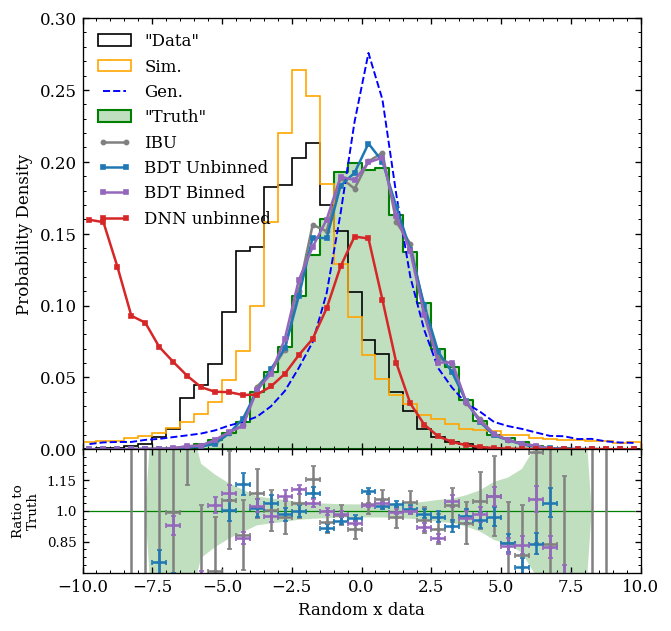

In [15]:
hist_style = {'histtype': 'step', 'density': True, 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '--', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '"Truth"'}
ibu_style = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'gray', 'zorder': 1}
dnn_unbinned_multi_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:red', 'zorder': 3}
bdt_unbinned_multi_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:orange', 'zorder': 3}
bdt_binned_single_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:purple', 'zorder': 3}
bdt_unbinned_single_style = {'ls': '-', 'marker': 's', 'ms': 2.5, 'color': 'tab:blue', 'zorder': 3}
fig, [ax0, ax1] = modplot.axes(figsize=(6,6), xlabel="Random x data", xlim=(MC_low, MC_high), ylim=(0,0.3))
        
# Plot the Different Distributions of the Observable
ax0.hist(unbinned_measured_data[measured_pass_reco], bins=sim_bins, range=(sim_low, sim_high), color='black', label='"Data"', **hist_style)
ax0.hist(unbinned_sim_data[sim_pass_reco], bins=sim_bins, range=(sim_low, sim_high), color='orange', label='Sim.', **hist_style)
MC_hist, MC_bin_edges =  np.histogram(unbinned_MC_data[sim_pass_truth], bins=MC_bins, range=(MC_low, MC_high), density=True)
MC_bin_centers = (MC_bin_edges[:-1] + MC_bin_edges[1:]) / 2
ax0.plot(MC_bin_centers,MC_hist, **gen_style)

truth_hist, truth_bin_errors = modplot.calc_hist(unbinned_true_data[measured_pass_truth], bins=MC_bins, hist_range=(MC_low, MC_high), 
                                                               density=True)[:2]
_, truth_bin_edges =  np.histogram(unbinned_true_data[measured_pass_truth], bins=MC_bins, range=(MC_low, MC_high), density=True)
truth_bin_centers = (truth_bin_edges[:-1] + truth_bin_edges[1:]) / 2

ax0.fill_between(truth_bin_centers, truth_hist, **truth_style)

# plot the IBU distribution
ax0.plot(ibu_bin_centers, ibu_density_counts, **ibu_style, label='IBU')
print(unbinned_MC_data.flatten().shape, omnifold_dnn_weights.shape)

dnn_unbinned_unfolded_hist, dnn_unbinned_unfolded_hist_errors = modplot.calc_hist(
        unbinned_MC_data[sim_pass_truth].flatten(), 
        weights=omnifold_dnn_weights[sim_pass_truth], 
        bins=MC_bins,
        hist_range=(MC_low, MC_high),
        density=True
)[:2]
unbinned_unfolded_hist, unbinned_unfolded_hist_errors = modplot.calc_hist(
    MC_entries_unbinned.flatten(), 
    weights=unbinned_weights[-1][1], 
    bins=MC_bins,
    hist_range=(MC_low, MC_high),
    density=True
)[:2]

# compute which bins the values are in
binned_unfolded_hist, binned_unfolded_hist_errors = modplot.calc_hist(
    binned_MC_entries.flatten(), 
    weights=binned_weights[-1][1], 
    bins=MC_bins,
    hist_range=(MC_low, MC_high),
    density=True,
    efficiency = efficiencies_np
)[:2]

ax0.plot(truth_bin_centers, unbinned_unfolded_hist, **bdt_unbinned_single_style, label='BDT Unbinned')
ax0.plot(truth_bin_centers, binned_unfolded_hist, **bdt_binned_single_style, label='BDT Binned')
ax0.plot(truth_bin_centers, dnn_unbinned_unfolded_hist, **dnn_unbinned_multi_style, label='DNN unbinned')

# Plot the Ratios of the OmniFold and IBU distributions to truth (with statistical uncertainties)
ibu_ratio = ibu_density_counts / (truth_hist + 10**-50)

of_ratio_bdt_unbinned_single = unbinned_unfolded_hist /(truth_hist + 10**-50)
of_ratio_bdt_binned_single = binned_unfolded_hist /(truth_hist + 10**-50)
ax1.plot([np.min(truth_bin_centers), np.max(truth_bin_centers)], [1, 1], '-', color='green', lw=0.75)
    
# ratio uncertainties
truth_unc_ratio = truth_bin_errors / (truth_hist + 10**-50)

ibu_unc_ratio = ibu_bin_errors / (truth_hist + 10**-50)
of_unc_ratio_bdt_unbinned_single = unbinned_unfolded_hist_errors / (truth_hist + 10**-50)
of_unc_ratio_bdt_binned_single = binned_unfolded_hist_errors / (truth_hist + 10**-50)

ax1.fill_between(
    truth_bin_centers, 
    1 - truth_unc_ratio, 
    1 + truth_unc_ratio,          
    facecolor=truth_style['facecolor'], 
    zorder=-2
)
    
ax1.errorbar(
    ibu_bin_centers, 
    ibu_ratio, 
    xerr=(ibu_bin_centers[1]-ibu_bin_centers[0])/2, 
    yerr=ibu_unc_ratio,                       
    color=ibu_style['color'], 
    **modplot.style('errorbar')
)

truth_binwidth = (truth_bin_centers[1]-truth_bin_centers[0])/2

ax1.errorbar(
    truth_bin_centers, 
    of_ratio_bdt_unbinned_single, 
    xerr=truth_binwidth, 
    yerr=of_unc_ratio_bdt_unbinned_single, 
    color=bdt_unbinned_single_style['color'], 
    **modplot.style('errorbar')
) # Binned Error Bar

ax1.errorbar(
    truth_bin_centers, 
    of_ratio_bdt_binned_single, 
    xerr=truth_binwidth, 
    yerr=of_unc_ratio_bdt_binned_single, 
    color=bdt_binned_single_style['color'], 
    **modplot.style('errorbar')
) # Binned Error Bar


# legend style and ordering
modplot.legend(ax=ax0, frameon=False, loc="upper left", ncol=1)
fig.savefig(f'./plots/OmniFold_Gaussian_noDNN.png', bbox_inches='tight')

In [16]:
def triangular_discriminator(p, q):
    p = np.array(p)
    q = np.array(q)
    if len(p) != len(q):
        print("Error: The distributions 'p' and 'q' must have the same length.")
        return None
    
    epsilon = 1e-50
    discriminator = np.sum((p - q)**2 / (p + q + epsilon))
    return 0.5 * discriminator

In [17]:
data_hist, _ = np.histogram(unbinned_measured_data[measured_pass_reco], bins=sim_bins, range=(sim_low, sim_high), density=True)

discriminator_values = {
'dnn_unbinned': triangular_discriminator(dnn_unbinned_unfolded_hist, truth_hist),
'bdt_unbinned': triangular_discriminator(unbinned_unfolded_hist, truth_hist),
'bdt_binned': triangular_discriminator(binned_unfolded_hist, truth_hist),
'ibu': triangular_discriminator(ibu_density_counts, truth_hist),
'data': triangular_discriminator(data_hist, truth_hist),
'gen': triangular_discriminator(MC_hist, truth_hist)
}
print(discriminator_values)

{'dnn_unbinned': 0.6556586395332805, 'bdt_unbinned': 0.0026151118594242894, 'bdt_binned': 0.0021680572437918185, 'ibu': 0.003300534159798949, 'data': 0.5186569284994066, 'gen': 0.10428665489671499}
